In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  
import tensorflow as tf
import keras
from keras import layers, ops, Model, random

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# Normalize the dataset
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)
# merge test and training
x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))
del x_test, y_test

In [4]:
print(x_train.shape, y_train.shape)

(70000, 28, 28, 1) (70000,)


In [5]:
# Split training data into 50% train, 25% validation, 25% test
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

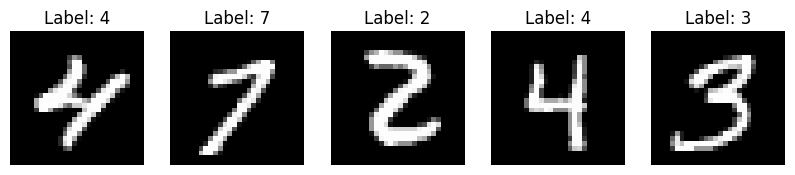

In [6]:
# Visualize some digits from the dataset
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(x_test[digits[i]].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y_test[digits[i]]}")
    ax.axis('off')
plt.show()

# VAE Generator

In [16]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [17]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(4, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(2, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(8, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# --------------------------------------------------------
# Decoder
# --------------------------------------------------------
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 2, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 2))(x)
x = layers.Conv2DTranspose(4, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(1, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14, 4) │         40 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 7, 7, 2)   │         74 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 98)        │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        792 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         18 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         18 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 942 (3.68 KB)

 Trainable params: 942 (3.68 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 98)             │           294 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 4)      │            76 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 1)      │            37 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 1)      │            10 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417 (1.63 KB)

 Trainable params: 417 (1.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # --------- MSE reconstruction loss ---------
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.mean_squared_error(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [19]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [20]:
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")

# Train the autoencoder on the training data
history = vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 1.9322 - loss: 125.5361 - reconstruction_loss: 123.6040
Epoch 2/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 1.7611 - loss: 56.0637 - reconstruction_loss: 54.3026
Epoch 3/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 1.5415 - loss: 52.8203 - reconstruction_loss: 51.2787
Epoch 4/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 1.4054 - loss: 51.6104 - reconstruction_loss: 50.2050
Epoch 5/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 1.3690 - loss: 50.6561 - reconstruction_loss: 49.2871
Epoch 6/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 1.3151 - loss: 50.2986 - reconstruction_loss: 48.9835
Epoch 7/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 1.2709 - loss: 49.8824 - reconstruction_loss: 48.6116
Epoch 8/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 1.2520 - loss: 49.6997 - reconstruction_loss: 48.4478
Epoch 9/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss:

In [21]:
def generate_random_images(decoder, latent_dim, n=10):
    # Sample random points in the latent space
    z_random = np.random.normal(size=(n, latent_dim))

    # Decode them into images
    generated = decoder.predict(z_random)

    # Plot
    plt.figure(figsize=(n, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = generated[i].squeeze()  # shape (28,28) or (28,28,1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


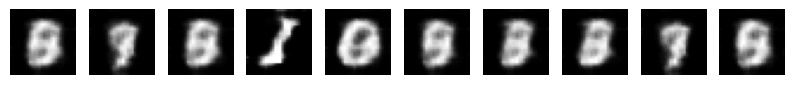

In [22]:
generate_random_images(decoder, latent_dim=2, n=10)


# GAN Generator

In [7]:
# ==========
# Hyperparameters
# ==========
latent_dim = 100
img_shape = (28, 28, 1)
batch_size = 128
epochs = 5  # change as you like


In [8]:
# ==========
# Generator
# ==========
def build_generator(latent_dim):
    noise = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128)(noise)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((7, 7, 128))(x)

    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)

    # Output: 28x28x1, values in [0,1] using sigmoid
    img = layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid")(x)

    return Model(noise, img, name="generator")

In [9]:
# ==========
# Discriminator
# ==========
def build_discriminator(img_shape):
    img_input = layers.Input(shape=img_shape)

    x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(img_input)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = layers.LeakyReLU(0.2)(x)
    validity = layers.Dense(1, activation="sigmoid")(x)

    return Model(img_input, validity, name="discriminator")


In [10]:
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)

discriminator.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=["accuracy"],
)


In [11]:
# ==========
# Combined model (Generator + frozen Discriminator)
# ==========
discriminator.trainable = False

z = layers.Input(shape=(latent_dim,))
img = generator(z)
valid = discriminator(img)

combined = Model(z, valid, name="combined")
combined.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
)


In [13]:
# ==========
# Training loop
# ==========

# Use your x_train from the split you did earlier
X_real = x_train.astype("float32")   # already in [0,1] and shape (28,28,1)

half_batch = batch_size // 2
steps_per_epoch = X_real.shape[0] // batch_size

for epoch in range(1, epochs + 1):
    for step in range(steps_per_epoch):

        # ---- Train Discriminator ----
        # Real images
        idx = np.random.randint(0, X_real.shape[0], half_batch)
        real_imgs = X_real[idx]

        # Fake images
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_imgs = generator.predict(noise, verbose=0)

        # Labels: real=1, fake=0
        real_y = np.ones((half_batch, 1))
        fake_y = np.zeros((half_batch, 1))

        # train_on_batch trains the model applying backprop etc. 
        # we only apply it on the discriminator, so we don't need to freeze
        # the generator (this is done effectively by never calling generator.train_on_batch
        d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---- Train Generator ----
        # here instead we call a combined model (see previous cell), defined
        # as the pipeline of the generator and the *frozen* discriminator. 
        # The generator is trained on pure noise, no need to pass the real images
        # we set the labels to one (real images) even if these are fakes, because we
        # want to find the theta values of the generator parameter that would make the
        # discriminator answer with a number close to one. So, the ground truth is 
        # set to one as a target of the generator training
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.ones((batch_size, 1))

        g_loss = combined.train_on_batch(noise, valid_y)

    print(f"Epoch {epoch}/{epochs} - D loss: {d_loss[0]}, D acc: {d_loss[1]*100}%, G loss: {g_loss}")


Epoch 1/5 - D loss: 0.8598937392234802, D acc: 35.04303991794586%, G loss: [array(0.86023253, dtype=float32), array(0.86023253, dtype=float32), array(0.35014665, dtype=float32)]
Epoch 2/5 - D loss: 0.9285244941711426, D acc: 33.73979926109314%, G loss: [array(0.92870766, dtype=float32), array(0.92870766, dtype=float32), array(0.337253, dtype=float32)]
Epoch 3/5 - D loss: 0.9621570706367493, D acc: 33.35679769515991%, G loss: [array(0.9622887, dtype=float32), array(0.9622887, dtype=float32), array(0.3334704, dtype=float32)]
Epoch 4/5 - D loss: 0.983323335647583, D acc: 33.1024169921875%, G loss: [array(0.98342496, dtype=float32), array(0.98342496, dtype=float32), array(0.3309508, dtype=float32)]
Epoch 5/5 - D loss: 0.9978996515274048, D acc: 33.00575613975525%, G loss: [array(0.99797785, dtype=float32), array(0.99797785, dtype=float32), array(0.32999867, dtype=float32)]


In [14]:
# ==========
# Generate some samples
# ==========
import matplotlib.pyplot as plt

def show_generated_images(generator, n=25):
    noise = np.random.normal(0, 1, (n, latent_dim))
    gen_imgs = generator.predict(noise, verbose=0)

    gen_imgs = gen_imgs.squeeze()  # (n, 28, 28)
    plt.figure(figsize=(5,5))
    for i in range(n):
        plt.subplot(5, 5, i+1)
        plt.imshow(gen_imgs[i], cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

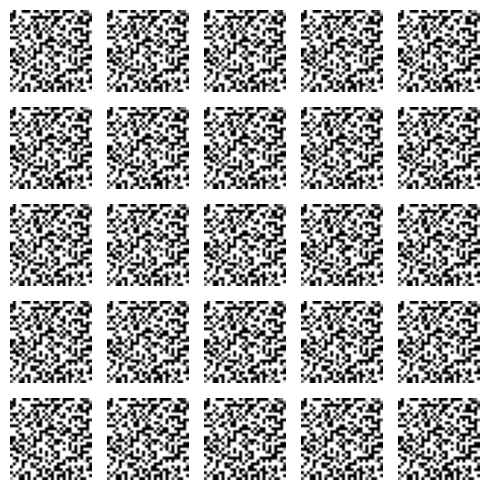

In [15]:
show_generated_images(generator, n=25)